In [1]:
import importlib
import JeffUtils
importlib.reload(JeffUtils)

<module 'JeffUtils' from 'C:\\Users\\j3ff1\\Documents\\School Work\\MLProjects\\TelecomChurnAnalysis\\JeffUtils.py'>

data from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm 
import matplotlib.pyplot as plt
import math
import scipy
import re

In [3]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder,OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix

In [6]:
pd.set_option('display.max_columns', None)

# Loading Raw Data

In [7]:
raw_data = pd.read_csv('telecomChurn.zip')

In [8]:
raw_data.head(5)

rev_Mean  mou_Mean  totmrc_Mean  da_Mean  ovrmou_Mean  ovrrev_Mean  \
0   23.9975    219.25       22.500   0.2475         0.00          0.0   
1   57.4925    482.75       37.425   0.2475        22.75          9.1   
2   16.9900     10.25       16.990   0.0000         0.00          0.0   
3   38.0000      7.50       38.000   0.0000         0.00          0.0   
4   55.2300    570.50       71.980   0.0000         0.00          0.0   

   vceovr_Mean  datovr_Mean  roam_Mean  change_mou  change_rev  drop_vce_Mean  \
0          0.0          0.0        0.0     -157.25    -18.9975       0.666667   
1          9.1          0.0        0.0      532.25     50.9875       8.333333   
2          0.0          0.0        0.0       -4.25      0.0000       0.333333   
3          0.0          0.0        0.0       -1.50      0.0000       0.000000   
4          0.0          0.0        0.0       38.50      0.0000       9.666667   

   drop_dat_Mean  blck_vce_Mean  blck_dat_Mean  unan_vce_Mean  unan_dat_Mean  \
0            0.0       0.666667            0.0       6.333333            0.0   
1            0.0       1.000000            0.0      61.333333            0.0   
2            0.0       0.000000            0.0       2.666667            0.0   
3            0.0       0.000000            0.0       0.000000            0.0   
4            0.0       0.666667            0.0      77.000000            0.0   

   plcd_vce_Mean  plcd_dat_Mean  recv_vce_Mean  recv_sms_Mean  comp_vce_Mean  \
0      52.333333            0.0      42.333333            0.0      45.000000   
1     263.333333            0.0      69.000000            0.0     193.333333   
2       9.000000            0.0       0.333333            0.0       6.000000   
3       3.666667            0.0       1.333333            0.0       3.666667   
4     222.333333            0.0      94.666667            0.0     137.000000   

   comp_dat_Mean  custcare_Mean  ccrndmou_Mean  cc_mou_Mean  inonemin_Mean  \
0            0.0       0.000000       0.000000     0.000000      18.000000   
1            0.0       1.666667       6.333333     5.463333      53.000000   
2            0.0       0.000000       0.000000     0.000000       0.333333   
3            0.0       0.000000       0.000000     0.000000       1.333333   
4            0.0       8.666667      15.000000    11.076667      66.000000   

   threeway_Mean  mou_cvce_Mean  mou_cdat_Mean  mou_rvce_Mean  \
0       0.000000      90.643333            0.0      97.176667   
1       0.333333     189.396667            0.0      55.280000   
2       0.000000       5.426667            0.0       0.000000   
3       0.000000       8.410000            0.0       0.413333   
4       0.000000     285.233333            0.0     106.330000   

   owylis_vce_Mean  mouowylisv_Mean  iwylis_vce_Mean  mouiwylisv_Mean  \
0         0.000000         0.000000         0.000000         0.000000   
1        46.333333        24.216667         6.333333         3.696667   
2         0.000000         0.000000         0.000000         0.000000   
3         0.333333         0.256667         0.000000         0.000000   
4        14.666667        10.816667         0.666667         0.366667   

   peak_vce_Mean  peak_dat_Mean  mou_peav_Mean  mou_pead_Mean  opk_vce_Mean  \
0      58.000000            0.0     132.600000            0.0     24.000000   
1      83.666667            0.0      75.333333            0.0    157.000000   
2       5.000000            0.0       5.193333            0.0      1.000000   
3       1.333333            0.0       3.380000            0.0      3.666667   
4      97.333333            0.0     173.476667            0.0     90.333333   

   opk_dat_Mean  mou_opkv_Mean  mou_opkd_Mean  drop_blk_Mean  attempt_Mean  \
0           0.0      55.220000            0.0       1.333333     52.333333   
1           0.0     169.343333            0.0       9.333333    263.333333   
2           0.0       0.233333            0.0       0.333333      9.000000   
3           0.0       5.45000

## Handling column descriptions

Since there is literally a hundred columns in this dataset, lets take a general look at what kind of data is available. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import OPTICS, KMeans
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import spacy

### read-in column descriptions

In [10]:
col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()

In [11]:
col_desc.head(5)

col_desc
rev_Mean        Mean monthly revenue (charge amount)
mou_Mean       Mean number of monthly minutes of use
totmrc_Mean      Mean total monthly recurring charge
da_Mean      Mean number of directory assisted calls
ovrmou_Mean              Mean overage minutes of use

### Preprocess column descriptions

In [12]:
col_desc['clean_desc'] = (
    col_desc['col_desc']
    .apply(gensim.parsing.preprocessing.remove_stopwords)
)

col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('[^a-zA-Z0-9_ ]','')
)

col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('  ',' ')
)

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
col_desc['tokenized'] = col_desc['clean_desc'].apply(lambda x: [token.lemma_ for token in nlp(x)])
col_desc['lemmatized'] = col_desc['tokenized'].apply(lambda x: ' '.join(x))

In [15]:
col_desc

col_desc  \
rev_Mean          Mean monthly revenue (charge amount)   
mou_Mean         Mean number of monthly minutes of use   
totmrc_Mean        Mean total monthly recurring charge   
da_Mean        Mean number of directory assisted calls   
ovrmou_Mean                Mean overage minutes of use   
...                                                ...   
kid11_15       Child 11 - 15 years of age in household   
kid16_17       Child 16 - 17 years of age in household   
creditcd                         Credit card indicator   
eqpdays      Number of days (age) of current equipment   
Customer_ID                                          N   

                                       clean_desc  \
rev_Mean       Mean monthly revenue charge amount   
mou_Mean          Mean number monthly minutes use   
totmrc_Mean   Mean total monthly recurring charge   
da_Mean      Mean number directory assisted calls   
ovrmou_Mean              Mean overage minutes use   
...                                           ...   
kid11_15          Child 11 15 years age household   
kid16_17          Child 16 17 years age household   
creditcd                    Credit card indicator   
eqpdays         Number days age current equipment   
Customer_ID                                     N   

                                            tokenized  \
rev_Mean     [mean, monthly, revenue, charge, amount]   
mou_Mean         [mean, number, monthly, minute, use]   
totmrc_Mean     [mean, total, monthly, recur, charge]   
da_Mean       [mean, number, directory, assist, call]   
ovrmou_Mean              [mean, overage, minute, use]   
...                                               ...   
kid11_15        [child, 11, 15, year, age, household]   
kid16_17        [child, 16, 17, year, age, household]   
creditcd                    [credit, card, indicator]   
eqpdays        [number, day, age, current, equipment]   
Customer_ID                                       [n]   

                                     lemmatized  
rev_Mean     mean monthly revenue charge amount  
mou_Mean         mean number monthly minute use  
totmrc_Mean     mean total monthly recur charge  
da_Mean       mean number directory assist call  
ovrmou_Mean             mean overage minute use  
...                                         ...  
kid11_15         child 11 15 year age household  
kid16_17         child 16 17 year age household  
creditcd                  credit card indicator  
eqpdays        number day age current equipment  
Customer_ID                                   n  

[100 rows x 4 columns]

### Bag of words

In [16]:
tokenizedDesc = col_desc['lemmatized'].apply(lambda x: x.split()).to_list()
dictionary = gensim.corpora.Dictionary(tokenizedDesc)
corpus = [dictionary.doc2bow(text) for text in tokenizedDesc]

### Tfidf

In [17]:
dictionary = gensim.corpora.Dictionary(col_desc['tokenized'])
corpus = [dictionary.doc2bow(text) for text in col_desc['tokenized']]

In [18]:
tfidf = TfidfVectorizer()
tfidfMatrix = tfidf.fit_transform(col_desc['lemmatized'])

### LDA grouping

In [19]:
# import pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()

In [33]:
ldas = []
for n in range(3,16):
    lda = gensim.models.ldamodel.LdaModel(
        corpus, num_topics=n,id2word=dictionary, random_state=1337
    )
    ldas.append((n,lda))

In [34]:
coher_scores = []
listed_tokens = col_desc['tokenized'].to_list()
for lda_tup in ldas:
    coher_model = CoherenceModel(model=lda_tup[1], texts=listed_tokens, dictionary=dictionary, coherence='c_v')
    coher_scores.append((lda_tup[0],coher_model.get_coherence()))

In [55]:
coher_scores

[(3, 0.5067327030933383),
 (4, 0.5228109088095966),
 (5, 0.4975643925681844),
 (6, 0.484679537033542),
 (7, 0.4777373076042672),
 (8, 0.4800708640499987),
 (9, 0.47900234265635877),
 (10, 0.49272810795529887),
 (11, 0.4838953474770993),
 (12, 0.5076580159522219),
 (13, 0.4988016907739328),
 (14, 0.5153082055690436),
 (15, 0.5053040277667462)]

### Optics grouping

In [42]:
from JeffUtils import graph_cluster_wc, graph_elbow

In [21]:
optics = OPTICS(min_samples=3)
col_desc['optics_class'] = optics.fit_predict(tfidfMatrix.toarray())

In [22]:
col_desc.optics_class.value_counts()

-1    51
 6     8
 2     8
 5     6
 9     5
 4     5
 1     5
 0     3
 8     3
 7     3
 3     3
Name: optics_class, dtype: int64

In [108]:
np.floor(np.sqrt(col_desc.optics_class.nunique()))

3.0

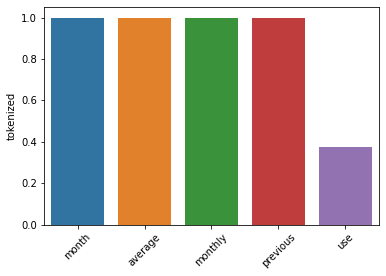

In [111]:

graph_cluster_wc(col_desc,'tokenized','optics_class',2)

### kmeans grouping

In [61]:
from JeffUtils import graph_elbow

In [62]:
kmeans = []
for i in range(5,21):
    km = KMeans(n_clusters=i,random_state=1337)
    km.fit_predict(tfidfMatrix.toarray())
    kmeans.append((i,km.inertia_))

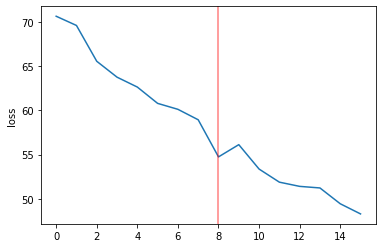

In [63]:
loss = pd.DataFrame(kmeans)[1].rename('loss')
elbow = graph_elbow(loss)

In [64]:
kmeans = KMeans(n_clusters=elbow)
col_desc['kmeans_class'] = kmeans.fit_predict(tfidfMatrix.toarray())

In [65]:
col_desc['kmeans_class'].value_counts()

0    25
1    19
7    13
2    11
4    10
6     8
5     8
3     6
Name: kmeans_class, dtype: int64

In [66]:
ls = []
for group in col_desc['kmeans_class'].unique():
    ls.append(col_desc[col_desc['kmeans_class']==group]['col_desc'].to_numpy())

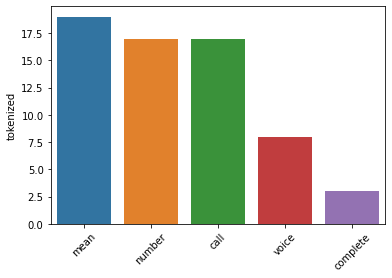

In [92]:
graph_cluster_wc(col_desc,'tokenized','kmeans_class',1)